# Pytorch Dataloders for Jax
> Modifying pytorch dataloaders to work with Jax

- toc: true
- badges: true
- comments: true
- categories: [deep_learning, jax]
- image: images/jax_loves_pytorch.png

# Motivation

I've recently experimented with [Jax](https://github.com/google/jax), Google's new deep learning framework. Overall, I have a good impression of it, with one exception: data loading. Both the [Jax tutorial](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb) and Google's [Vision Transformer](https://github.com/google-research/vision_transformer){% fn 1 %} use tensorflow datasets for data loading. To be honest, I'm not a big fan of this approach.

Fortunately, Pytorch has great data loaders! And they are not too hard to modify for Jax. I'll borrow [albumentation docs'](https://albumentations.ai/docs/examples/pytorch_classification/) code for downloading the Cats & Dogs dataset for illustration.

In [1]:
#collapse

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset_directory = "/mnt/data/cats-vs-dogs"

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n

def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)
    
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

random.seed(1)
random.shuffle(images_filepaths)
train_images_filepaths = [i for i in images_filepaths[:200] if cv2.imread(i) is not None]

print(f"Size of (example) training set: {len(train_images_filepaths)}")

print(f"Example file paths: ")
for i in range(5): print(train_images_filepaths[i])

Size of (example) training set: 199
Example file paths: 
/mnt/data/cats-vs-dogs/PetImages/Dog/442.jpg
/mnt/data/cats-vs-dogs/PetImages/Dog/6674.jpg
/mnt/data/cats-vs-dogs/PetImages/Cat/1243.jpg
/mnt/data/cats-vs-dogs/PetImages/Cat/3424.jpg
/mnt/data/cats-vs-dogs/PetImages/Cat/5531.jpg


The images have varying shapes; for this example I'm using opencv to load them (PIL would work just as well).

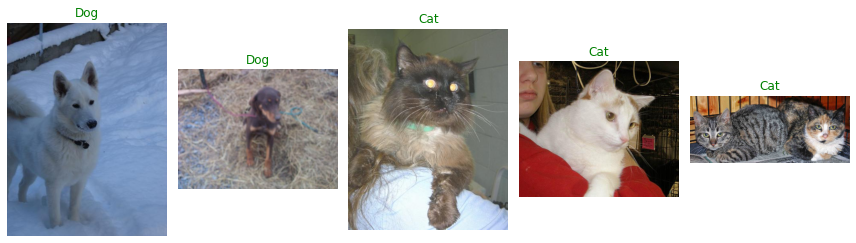

In [2]:
display_image_grid(train_images_filepaths[:5])

# Creating a Dataset

To create a standard Pytorch dataset, we subclass it and implement a `__length__` and `__getitem__` method:

In [3]:
class Dataset():
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError

We're going to use the example dataset from the [albumentation](https://albumentations.ai/docs/examples/pytorch_classification/) docs:

In [4]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

So far, there is nothing new. Our dataset is an object we can index into, and it returns numpy array along with binary label.

In [5]:
dataset = CatsVsDogsDataset(train_images_filepaths)

dataset[3][0].shape, dataset[0][1]

((424, 500, 3), 0.0)

# Adding transforms

Since we're going along the albumentations tutorial, adding transforms comes out of the box. The only change to be aware of: don't add a `ToTensor` conversion as we won't use pytorch!

In [6]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)
dataset = CatsVsDogsDataset(train_images_filepaths, transform=train_transform)

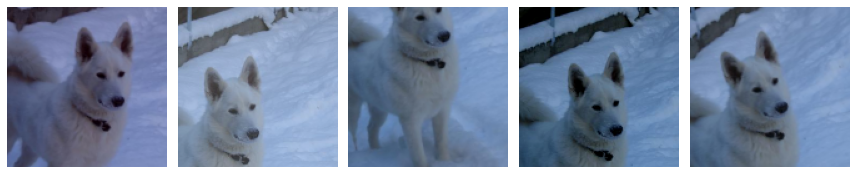

In [7]:
#collapse
def visualize_augmentations(dataset, idx=0, samples=5, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

random.seed(42)
visualize_augmentations(dataset)

Of course, we can use any other data augmentation library, or even build our own from scratch. Doing the latter might be worthwhile for two reasons:
1. since Jax uses a very-numpy-like API, implementing (batched) transformations on the GPU shouldn't be too hard.
1. albumentations uses a different random seed generator, for reproducibility it's best to use the one from Jax.

Anyway, for this example, using Albumentations will suffice.

# Sampler

The sampler is the first modification. We want to rely on jax's random number generator instead of the one built into Pytorch, making random number generation very explicit. 

To implement a sampler, we just have to create an iterator over indices. Sampling sequentially works for a validation set, but for training, we want to shuffle the data.

In [11]:
import jax
import jax.numpy as jnp

from torch.utils.data import Sampler, SequentialSampler

class RandomSampler(Sampler):
    
    def __init__(self, data_source, rng_key):
        self.data_source = data_source
        self.rng_key = rng_key
        
    def __len__(self):
        return len(self.data_source)
    
    def __iter__(self):
        self.rng_key, current_rng = jax.random.split(self.rng_key)
        return iter(jax.random.permutation(current_rng, jnp.arange(len(self))).tolist())

# DataLoader

Next, we have to modify the default collation method (so we don't get tensors). We'll use classic numpy instead of Jax, as we want to do these operations on the CPU (Jax GPU is not going to work with `num_workers > 0`), and have to put the whole batch to the GPU after it's assembled.

In [12]:
import numpy as np
from torch.utils.data import DataLoader

def stack_collate(batch):
    return [np.stack(x) for x in zip(*batch)]

class JaxDataLoader(DataLoader):
    
    def __init__(self, dataset, rng_key, batch_size=1, shuffle=False,
                 collate_fn=stack_collate,
                 **kwargs):
        
        if shuffle:
            sampler = RandomSampler(dataset, rng_key)
        else:
            sampler = SequentialSampler(dataset)
            
        super().__init__(dataset, batch_size, sampler=sampler,
                         collate_fn=collate_fn, **kwargs)

That's it! The main difference to pytorch is that we have to supply the random number key explicitly (which actually has quite a few benefits).

In [25]:
rng = jax.random.PRNGKey(0)
dl = JaxDataLoader(dataset, rng, 8, shuffle=True, collate_fn=stack_collate, num_workers=4)

We can inspect the first element of a batch the usual way:

In [26]:
xb, yb = next(iter(dl))

type(xb), xb.shape, type(yb), yb.shape

(numpy.ndarray, (8, 128, 128, 3), numpy.ndarray, (8,))

Plotting a batch is easy (it's just numpy!) since the spatial and channel axes are not reshuffled:

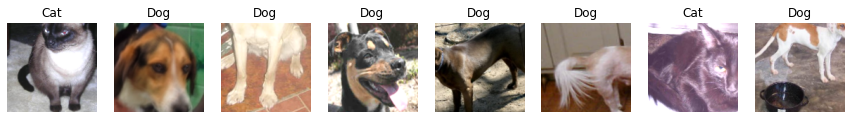

In [27]:
fig, axes = plt.subplots(1, 8, figsize = (15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(xb[i])
    ax.set_title("Cat" if yb[i] == 1.0 else "Dog")
    ax.set_axis_off()

We can easily put the numpy batch on the GPU:

In [28]:
jnp.array(xb).device()

GpuDevice(id=0, process_index=0)

To speed up data-loading, I used 4 worker threads:

In [29]:
%%timeit
for xb, yb in dl:
    jnp.array(xb)
jax.device_put(0.).block_until_ready()

150 ms ± 889 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The data loading speed is on-par with pytorch:

In [14]:
import torch
from torch.utils.data import DataLoader

torch_dl = DataLoader(dataset, 8, shuffle=True, num_workers=4)

In [21]:
%%timeit
for xb, yb in torch_dl:
    pass
torch.cuda.synchronize()

195 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Footnotes

{{ "The official ViT implementation seems to be in Jax. I like that Google is moving away from tensorflow" | fndetail: 1 }}